In [1]:
from dual_sourcing_game import DualSourcing
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions import Categorical
import math
from scipy.stats import norm

Matplotlib created a temporary config/cache directory at /var/folders/_x/fh3t8wcj3_xbs4fddcxmbpc00000gn/T/matplotlib-cx7wg4q1 because the default path (/Users/hansshen/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/Users/hansshen/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config={'regular_leadtime':8,'express_leadtime':2,'regular_cost':6,'express_cost':7,"max_order":8,"max_inventory":30,
       'store_cost':1.6,'back_cost':3.8,'y':0.95,'starting_state':[15,[0 for _ in range(8)],[0 for _ in range(2)]]}
episode_len=2000
episode_rep=600
game1=DualSourcing(config,episode_len=episode_len,episode_rep=episode_rep)
game2=DualSourcing(config,episode_len=episode_len,episode_rep=episode_rep)
game3=DualSourcing(config,episode_len=episode_len,episode_rep=episode_rep)

In [3]:
# Actor and Critic Policy Neural Network, pass in hidden_dimensions=[2,2,3], for example, would create 3 layers of 2d,2d,and 3d NN.
# only difference between the two is whether there's a softmax in the end
class actor_nn(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(actor_nn, self).__init__() 
        actor_modules = []
        last_dim = input_dim
        for hidden_dim in hidden_dims:
            actor_modules.append(nn.Linear(last_dim, hidden_dim))
            actor_modules.append(nn.ReLU())
            last_dim = hidden_dim
        actor_modules.append(nn.Linear(last_dim, output_dim))
        actor_modules.append(nn.Softmax(dim=-1))
        self.actor = nn.Sequential(*actor_modules)
        
    def forward(self, state):
        action_prob = self.actor(state)
        return action_prob
        
class critic_nn(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(critic_nn, self).__init__() 
        critic_modules = []
        last_dim = input_dim
        for hidden_dim in hidden_dims:
            critic_modules.append(nn.Linear(last_dim, hidden_dim))
            critic_modules.append(nn.ReLU())
            last_dim = hidden_dim
        critic_modules.append(nn.Linear(last_dim, 1))
        self.critic = nn.Sequential(*critic_modules)

    def forward(self, state):
        state_value = self.critic(state)
        return state_value

In [4]:
#initial exploration by epsilon greedy, must fine tune to ensure convergence
#epsilon greedy td_0 a2c agent, epsilon_dr=how quickly epsilon decreases
class greedy_td_0_A2C_agent:
    def __init__(self,dual_sourcing_env,actor_hidden_dims,critic_hidden_dims,actor_lr,critic_lr,
                epsilon=1,epsilon_dr=0.99,weight=1
                ):
        self.env=dual_sourcing_env
        #actor_input=critic_input=[inv,reg pipeline components,exp pipeline components]
        actor_input_dim=1+self.env.rl+self.env.el
        actor_output_dim=(self.env.max_order+1)**2
        actor_hidden_dims=actor_hidden_dims
        critic_input_dim=actor_input_dim
        critic_output_dim=1
        critic_hidden_dims=critic_hidden_dims
        self.actor=actor_nn(actor_input_dim,actor_output_dim,actor_hidden_dims)
        self.critic=critic_nn(critic_input_dim,critic_output_dim,critic_hidden_dims)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.action_space_size=actor_output_dim
        self.epsilon=epsilon
        self.epsilon_dr=epsilon_dr
        self.weight=weight
        self.actor_loss=0
        self.critic_loss=0
       
    # attempt epsilon greedy to encourage initial exploration
    # and epsilon decreases over time
    def act(self):
        self.epsilon=self.epsilon*self.epsilon_dr
        if self.epsilon>0.001 and np.random.uniform()<self.epsilon:
            #draw random action
            env_state=[self.env.state[0]]+self.env.state[1]+self.env.state[2]
            self.cur_state = torch.FloatTensor(env_state)
            action_prob=torch.FloatTensor([1/self.action_space_size]*self.action_space_size)
            action_dist = torch.distributions.Categorical(action_prob)
            action = action_dist.sample()
            reg_order=action.item()//(self.env.max_order+1)
            exp_order=action.item()%(self.env.max_order+1)
            self.env.step(reg_order,exp_order)
            next_env_state=[self.env.state[0]]+self.env.state[1]+self.env.state[2]
            self.next_state=torch.FloatTensor(next_env_state)
            #return log of action probability=None, and UPDATE CRITIC ONLY
            return None
        else:
            #draw action
            env_state=[self.env.state[0]]+self.env.state[1]+self.env.state[2]
            self.cur_state = torch.FloatTensor(env_state)
            action_prob = self.actor(self.cur_state)
            action_dist = torch.distributions.Categorical(action_prob)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            #perform action and see reward
            reg_order=action.item()//(self.env.max_order+1)
            exp_order=action.item()%(self.env.max_order+1)
            self.env.step(reg_order,exp_order)
            next_env_state=[self.env.state[0]]+self.env.state[1]+self.env.state[2]
            self.next_state=torch.FloatTensor(next_env_state)
            #return log of action probability
            return log_prob

    def update(self,log_prob):
        cur_state_value=self.critic(self.cur_state)
        next_state_value=self.critic(self.next_state)
        reward = torch.FloatTensor([self.env.reward])
        td_delta=reward+self.env.y*next_state_value-cur_state_value
        #update actor loss
        if log_prob:
            advantage = td_delta.detach() 
            self.actor_loss-=log_prob * advantage
        #update critic loss
        self.critic_loss+=td_delta.pow(2)
        
    def end_of_episode_update(self):
        combined_loss = self.actor_loss + self.weight*self.critic_loss 
        # Zero gradients
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        # Backpropagate combined loss
        combined_loss.backward()
        # Perform joint update
        self.actor_optimizer.step()
        self.critic_optimizer.step()
        # Reset for next episode
        self.actor_loss = 0
        self.critic_loss = 0

    def step(self):
        log_prob=self.act()
        self.update(log_prob)
    
    def opt_policy(self,inv,reg_orders,exp_orders):
        env_state=[inv]+reg_orders+exp_orders
        self.cur_state = torch.FloatTensor(env_state)
        action_prob = self.actor(self.cur_state)
        index = torch.argmax(action_prob)
        reg_order=index//(self.env.max_order+1)
        exp_order=index%(self.env.max_order+1)
        return reg_order,exp_order
        

In [ ]:
game1.reset()   
a=greedy_td_0_A2C_agent(game1,[4,8,4],[2,2],0.001,0.001)

for i in range(game1.total_episode_len):
    a.step()
    if i%game1.episode_len==0:
        a.end_of_episode_update()

In [ ]:
# a.opt_policy(-20,[2,0,0,0,0,2],[2,0])
# a.env.plot(21000,22000)

sum(a.env.reward_history[31000:32000])/1000


In [5]:
#comparing performance of heuristics(tailor based surge) and Reinforcement Learning Agent
#service level= the probability of not running out of stock in a given period. It is typically expressed as a percentage
class TBS_policy:
    def __init__(self,dual_sourcing_env,service_level=0.95):
        self.env=dual_sourcing_env
        self.Z= norm.ppf(service_level)
        self.avg_demand=0
        self.var_demand=0
        self.safety_stock=0
    def step(self):
        self.env.step(round(self.avg_demand),
                     round(max(0,self.safety_stock-self.env.state[0]-sum(self.env.state[1][i]+self.env.state[2][i] for i in range(self.env.el))))
                     )
        t=self.env.time_stamp
        cur_demand=self.env.demand_history[t-1]
        old_avg=self.avg_demand
        self.avg_demand+=1/t*(cur_demand-old_avg)
        self.var_demand=((t-1)*(self.var_demand)+(cur_demand-old_avg)*(cur_demand-self.avg_demand))/t
        self.safety_stock=self.avg_demand*self.env.el+self.Z*math.sqrt(self.env.el*self.var_demand) 


In [ ]:
game2.reset()   
b=TBS_policy(game2)
for i in range(game2.total_episode_len):
    b.step()

In [ ]:
sum(b.env.demand_history)/b.env.time_stamp

In [6]:
#initial exploration by tailored base surge. This uses monte-carlo and updates the actor and critic by the end of each episode
class TBS_td_0_A2C_agent:
    def __init__(self,dual_sourcing_env,actor_hidden_dims,critic_hidden_dims,actor_lr,critic_lr,
                exploration_ratio=0.05,weight=1
                ):
        self.env=dual_sourcing_env
        actor_input_dim=1+self.env.rl+self.env.el
        actor_output_dim=(self.env.max_order+1)**2
        actor_hidden_dims=actor_hidden_dims
        critic_input_dim=actor_input_dim
        critic_output_dim=1
        critic_hidden_dims=critic_hidden_dims
        self.actor=actor_nn(actor_input_dim,actor_output_dim,actor_hidden_dims)
        self.critic=critic_nn(critic_input_dim,critic_output_dim,critic_hidden_dims)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.action_space_size=actor_output_dim
        self.exploration_rounds=self.env.episode_len*exploration_ratio
        self.weight=weight
        self.actor_loss=0
        self.critic_loss=0
    def act(self):
        if self.env.time_stamp<self.exploration_rounds: 
            env_state=[self.env.state[0]]+self.env.state[1]+self.env.state[2]
            self.cur_state = torch.FloatTensor(env_state)
            #perform TBS action: consistently order amount close to demand from reg supplier
            #and maintain a safetystock surplus of backcost/(5*storecost)*demand with exp supplier
            past_demand=self.env.demand[self.env.time_stamp]
            reg_order=past_demand
            exp_order=max(0,self.env.bc/(5*self.env.sc)*past_demand-self.env.state[0])
            self.env.step(reg_order,exp_order)
            next_env_state=[self.env.state[0]]+self.env.state[1]+self.env.state[2]
            self.next_state=torch.FloatTensor(next_env_state)
            #return log of action probability=None, and UPDATE CRITIC ONLY
            return None
        else:
            #draw action
            env_state=[self.env.state[0]]+self.env.state[1]+self.env.state[2]
            self.cur_state = torch.FloatTensor(env_state)
            action_prob = self.actor(self.cur_state)
            action_dist = torch.distributions.Categorical(action_prob)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            #perform action and see reward
            reg_order=action.item()//(self.env.max_order+1)
            exp_order=action.item()%(self.env.max_order+1)
            self.env.step(reg_order,exp_order)
            next_env_state=[self.env.state[0]]+self.env.state[1]+self.env.state[2]
            self.next_state=torch.FloatTensor(next_env_state)
            #return log of action probability
            return log_prob

    def update(self,log_prob):
        cur_state_value=self.critic(self.cur_state)
        next_state_value=self.critic(self.next_state)
        reward = torch.FloatTensor([self.env.reward])
        td_delta=reward+self.env.y*next_state_value-cur_state_value
        #update actor loss
        if log_prob:
            advantage = td_delta.detach() 
            self.actor_loss-=log_prob * advantage
        #update critic loss
        self.critic_loss+=td_delta.pow(2)
        
    def end_of_episode_update(self):
        combined_loss = self.actor_loss + self.weight*self.critic_loss 
        # Zero gradients
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        # Backpropagate combined loss
        combined_loss.backward()
        # Perform joint update
        self.actor_optimizer.step()
        self.critic_optimizer.step()
        # Reset for next episode
        self.actor_loss = 0
        self.critic_loss = 0
    
    def step(self):
        log_prob=self.act()
        self.update(log_prob)
    
    def opt_policy(self,inv,reg_orders,exp_orders):
        env_state=[inv]+reg_orders+exp_orders
        self.cur_state = torch.FloatTensor(env_state)
        action_prob = self.actor(self.cur_state)
        index = torch.argmax(action_prob)
        reg_order=index//(self.env.max_order+1)
        exp_order=index%(self.env.max_order+1)
        return reg_order,exp_order

In [ ]:
game3.reset()   
c=TBS_td_0_A2C_agent(game3,[4,8,4],[4,4],0.001,0.001,exploration_ratio=0.1)
for i in range(game3.total_episode_len):
    c.step()
    if i%game3.episode_len==0:
        c.end_of_episode_update()

In [ ]:
sum(c.env.demand_history)/c.env.time_stamp

In [ ]:
#showing the learning process of the epsilon greedy and tbs-exploratory A2C Agents
fig=plt.figure(figsize=[12,10])
ax=fig.add_subplot(2,1,1)
ax.set_xlabel("Episode Number")
ax.set_ylabel("Average Reward Level")
epsilon_reward_matrix=np.reshape(a.env.reward_history[:a.env.episode_len*400],(400,a.env.episode_len))
tbsexplore_reward_matrix=np.reshape(c.env.reward_history[:a.env.episode_len*400],(400,c.env.episode_len))
epsilon_avg_rewards=np.mean(epsilon_reward_matrix,axis=1)
tbsexplore_avg_rewards=np.mean(tbsexplore_reward_matrix,axis=1)
ax.plot(epsilon_avg_rewards,label="epsilon-greedy A2C Agent")
ax.plot(tbsexplore_avg_rewards,label="TBS-exploratory A2C Agent")
ax.legend(loc='lower right')

In [23]:
#simultaed demand shock
new_config={'regular_leadtime':8,'express_leadtime':2,'regular_cost':6,'express_cost':7,"max_order":8,"max_inventory":30,
       'store_cost':1.6,'back_cost':3.8,'y':0.95,'starting_state':[15,[0 for _ in range(8)],[0 for _ in range(2)]]}
new_episode_len=2000
new_episode_rep=100
new_demand=[]
for i in range(new_episode_rep):
    first_half=np.random.poisson(2,new_episode_len//2)
    second_half=np.random.poisson(4,new_episode_len//2)
    new_demand+=[d+2 for d in first_half]
    new_demand+=[d+2 for d in second_half]
shock_game1=DualSourcing(config,episode_len=new_episode_len,episode_rep=new_episode_rep,demand=new_demand)
shock_game2=DualSourcing(config,episode_len=new_episode_len,episode_rep=new_episode_rep,demand=new_demand)

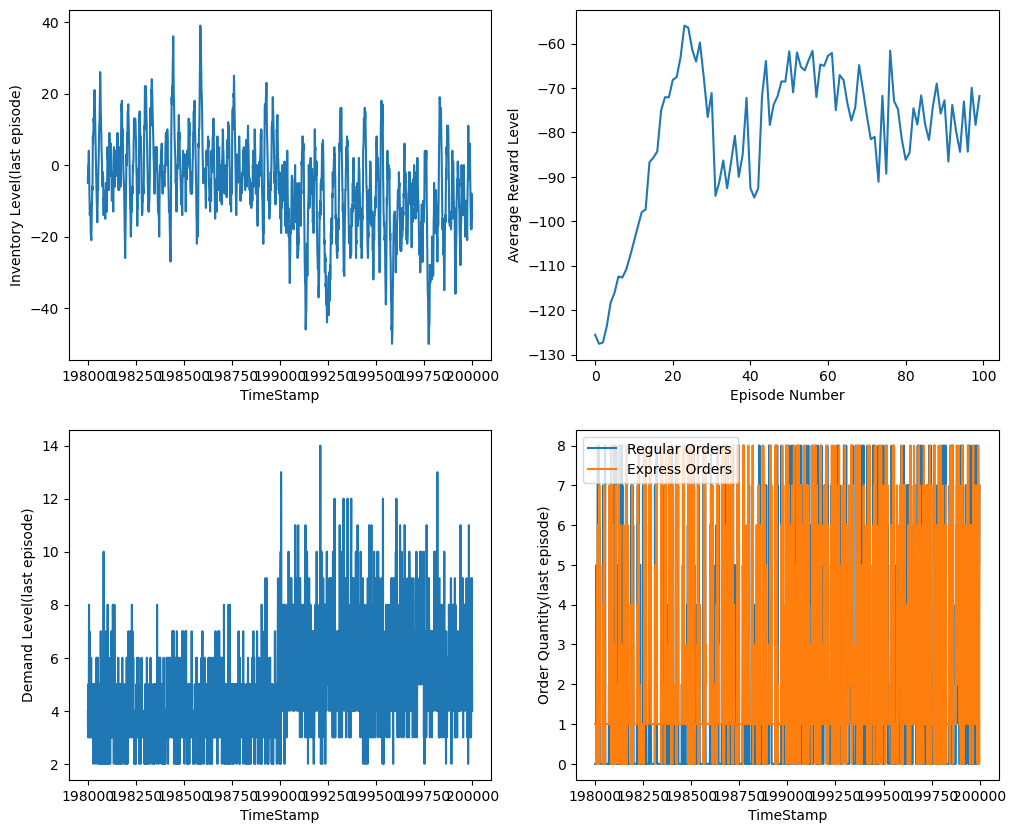

Info on Last Episode:
Avg Inventory Stock
-6.1085
Variance of Inventory Stock
171.37272775000017
Avg Inventory Holding(多出来的部分)
2.5475
Avg Inventory Backloss
8.656
Avg Cost per day
34.984675


In [24]:
shock_a=greedy_td_0_A2C_agent(shock_game1,[4,8,4],[2,2],0.005,0.005)
for i in range(shock_game1.total_episode_len):
    shock_a.step()
    if i%game1.episode_len==0:
        shock_a.end_of_episode_update()

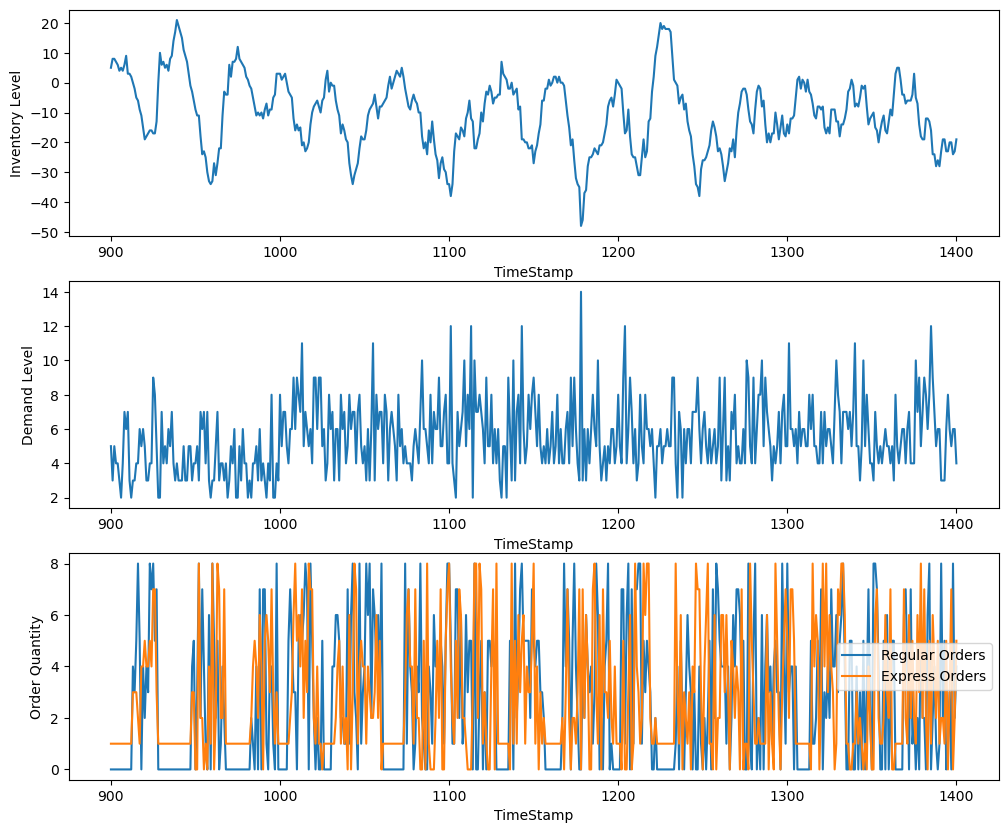

In [31]:
shock_a.env.plot((new_episode_rep-10)*new_episode_len+900,(new_episode_rep-10)*new_episode_len+1400)

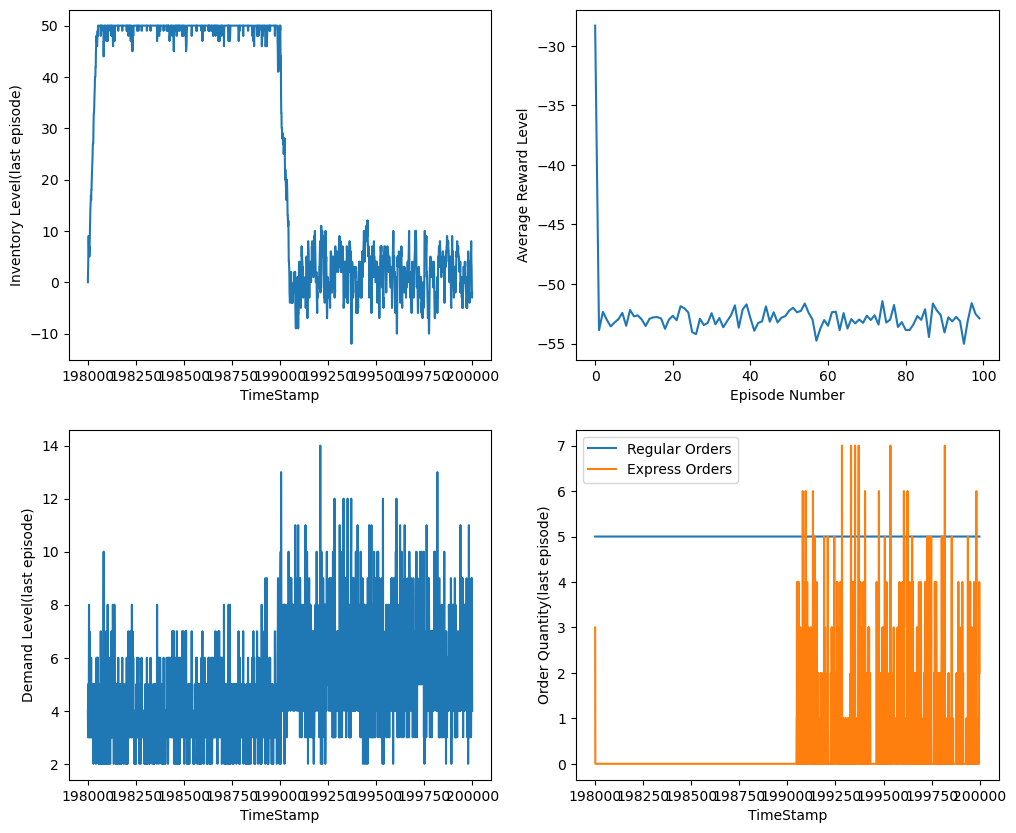

Info on Last Episode:
Avg Inventory Stock
25.4775
Variance of Inventory Stock
565.5994937499985
Avg Inventory Holding(多出来的部分)
25.9675
Avg Inventory Backloss
0.49
Avg Cost per day
39.610375


In [35]:
shock_b=TBS_policy(shock_game2,service_level=0.9)
for i in range(shock_game2.total_episode_len):
    shock_b.step()

In [15]:
#Real Life Dataset
import pandas as pd
df=pd.read_csv("./raw_data/processed_real_demand_data.csv")
real_demand=list(df["Order_Demand"])
config={'regular_leadtime':12,'express_leadtime':3,'regular_cost':3,'express_cost':4,"max_order":8,"max_inventory":50,
       'store_cost':0.85,'back_cost':1.8,'y':0.95,'starting_state':[25,[0 for _ in range(12)],[0 for _ in range(3)]]}
real_game1=DualSourcing(config,episode_len=len(real_demand),episode_rep=200,demand=real_demand*200)
real_game2=DualSourcing(config,episode_len=len(real_demand),episode_rep=200,demand=real_demand*200)

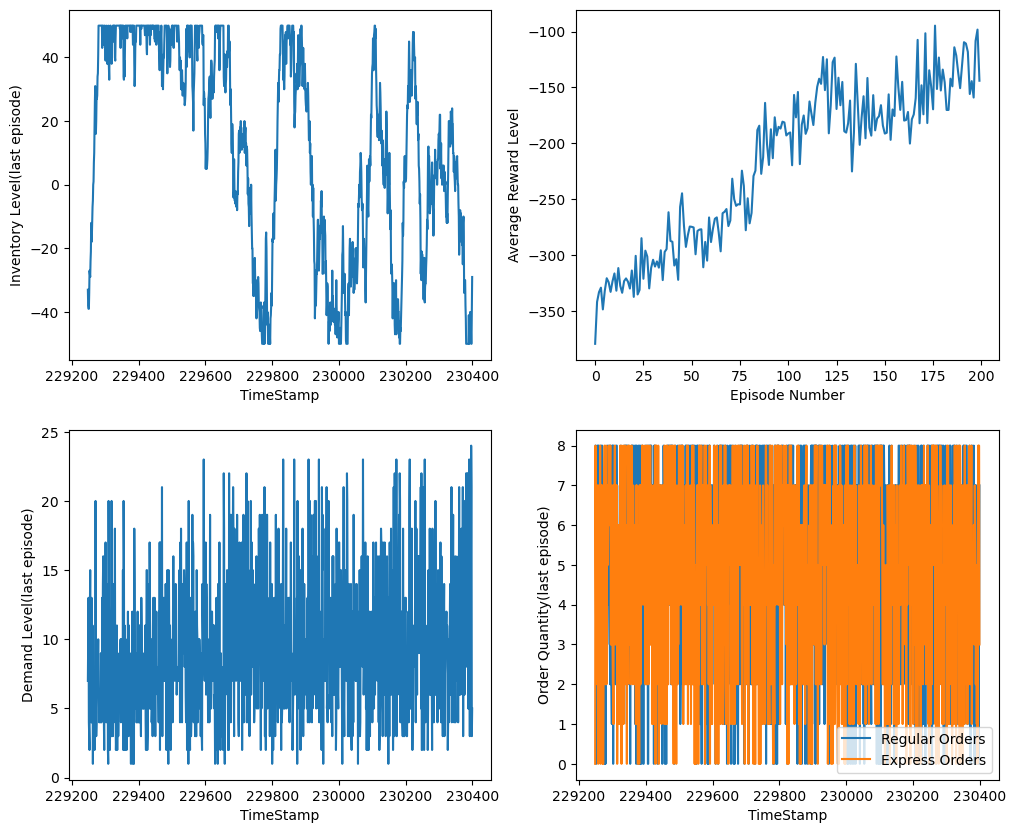

Info on Last Episode:
Avg Inventory Stock
12.215277777777779
Variance of Inventory Stock
1086.382474922841
Avg Inventory Holding(多出来的部分)
21.655381944444443
Avg Inventory Backloss
9.440104166666666
Avg Cost per day
69.55030381944444


In [20]:
real_game1.reset()
glaoshi=greedy_td_0_A2C_agent(real_game1,[4,4,4],[2,2],0.01,0.03,epsilon=0.6,epsilon_dr=0.8)
for i in range(real_game1.total_episode_len):
    glaoshi.step()
    if i%real_game1.episode_len==0:
        glaoshi.end_of_episode_update()

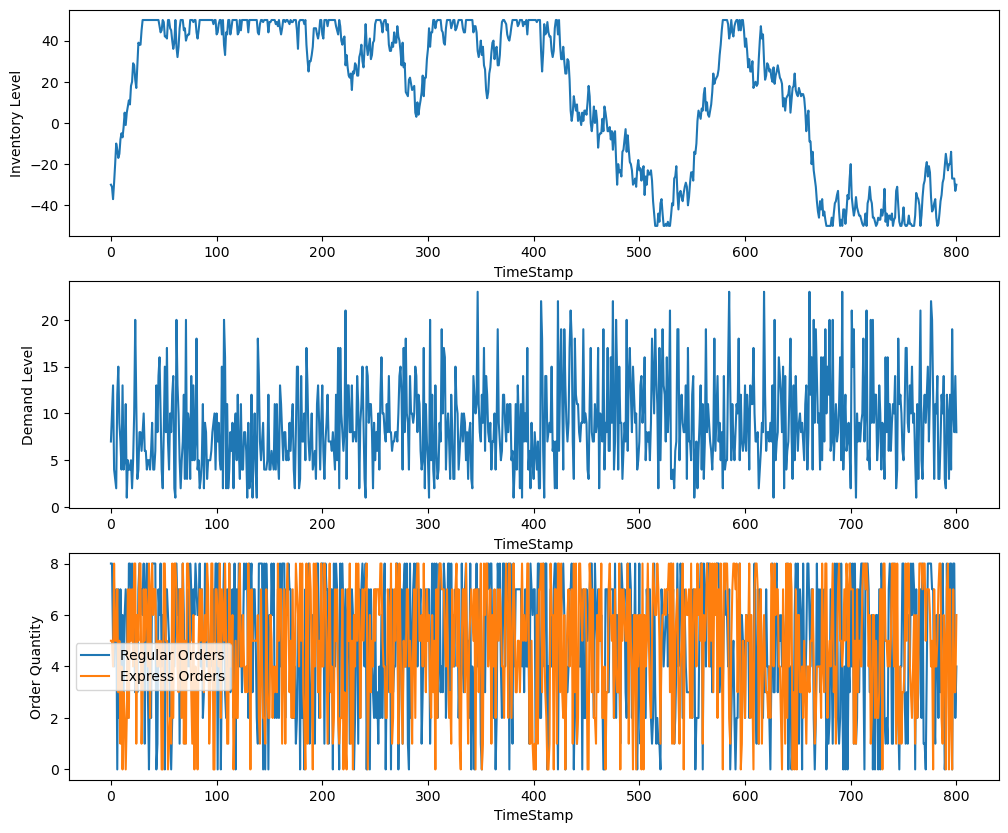

In [21]:
real_game1.plot((real_game1.episode_rep-21)*real_game1.episode_len,(real_game1.episode_rep-21)*real_game1.episode_len+800)

In [ ]:
real_game2.reset()
tbslaoshi=TBS_policy(real_game2,service_level=0.9)
for i in range(real_game2.total_episode_len):
    tbslaoshi.step()

In [ ]:
real_game2.plot(400,800)